# Simple Policy Optimization
Notebook for trying out the tooling involved in using policy gradient methods to train a model on SpaceInvaders.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
import numpy as np
tfd = tfp.distributions
%matplotlib inline

In [2]:
# Edge TPU for embedding extraction
from edgetpu.basic import basic_engine

In [3]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
# !pip install gym[box2d]

In [4]:
model_path = os.path.join(
    os.environ.get('HOME'), 'Work', 'ExternCode', 'edgetpu_models',
    'mobilenet_v1_1.0_224_quant_embedding_extractor_edgetpu.tflite')

In [5]:
tf.__version__

'2.1.0'

In [6]:
tf.executing_eagerly()

True

In [7]:
tfp.__version__

'0.9.0'

# Create Car Racing environment 

In [8]:
env_name = 'CarRacing-v0' # 'SpaceInvaders-v0'
env = gym.make(env_name)

In [9]:
env.observation_space

Box(96, 96, 3)

In [10]:
env.action_space

Box(3,)

Track generation: 1176..1478 -> 302-tiles track


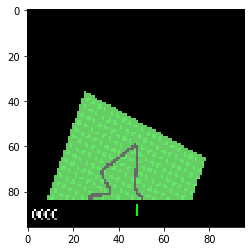

In [11]:
_ = plt.imshow(env.reset())

In [12]:
env.action_space.low, env.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [13]:
# Sampling from action space randomly
# tfd.Multinomial(total_count=1, logits=[-1.] * env.action_space.n).sample(1)
env.action_space.sample()

array([0.6642072 , 0.398046  , 0.93044287], dtype=float32)

# Next step: create h x w x n_frame tensor 
We can implement sequence of frames by allocating an initial h x w x n_frame tensor and for each new frame
rolling the tensor along axis 2 then assigning the new frame to channel 0. Is there a better or more idiomatic way to do this?
Could concatenate each new frame onto buffer.

In [14]:
n_row_col = 2
n_frame = n_row_col**2  # Square number for tiling
buffer = tf.zeros((n_frame,) + env.observation_space.shape, dtype=tf.uint8)

In [15]:
buffer.shape

TensorShape([4, 96, 96, 3])

In [16]:
# f = plt.figure()
for i in range(100):
    obs, reward, done, info = env.step(env.action_space.sample())
    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
#     _ = plt.imshow(buffer[0, ...])
#     plt.show()

In [17]:
def seq_to_img(seq, n):
    res = []
    for i in range(n):
        res.append(tf.concat([seq[i*n + j, ...] for j in range(n)], axis=1))
    return tf.concat(res, axis=0)

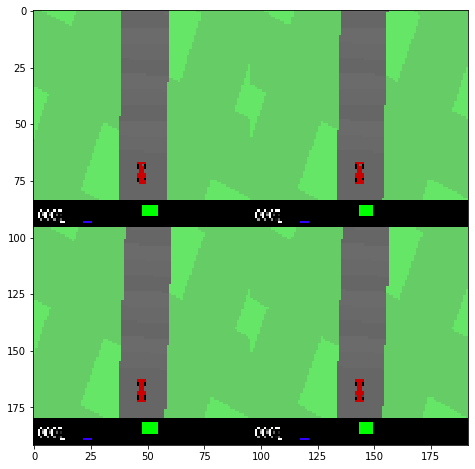

In [18]:
fig = plt.figure(figsize=(12,8))
# _ = plt.imshow(tf.reshape(tf.transpose(buffer, perm=[3, 2, 1, 0]), (2*96, 2*96, -1)))
_ = plt.imshow(seq_to_img(buffer, n_row_col))
ax = plt.gca()
# ax.axis('equal')
ax.set_aspect('equal', 'box')
# fig.savefig('test.png')

# Extract embedding
Use the MobileNet v1 model running on EdgeTPU to convert the set of n_frame frames represented as a single image into a 1024 element feature vector

In [19]:
engine = basic_engine.BasicEngine(model_path=model_path)

In [20]:
engine.get_all_output_tensors_sizes()

array([1024], dtype=int32)

In [21]:
_, img_ht, img_wd, _ = engine.get_input_tensor_shape()

In [22]:
buff_resized = tf.image.resize(seq_to_img(buffer, n_row_col), (img_ht, img_wd), method='nearest').numpy()

In [23]:
buff_resized.shape

(224, 224, 3)

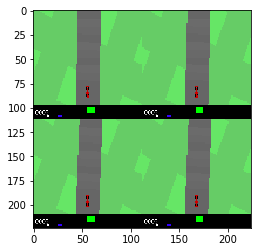

In [24]:
_ = plt.imshow(buff_resized)

In [25]:
_, _ = engine.run_inference(buff_resized.flatten()) # First run is slower, ignore
time_ms, embedding = engine.run_inference(buff_resized.flatten())
print(f'Time taken to extract embedding: {time_ms:.2f}ms')

Time taken to extract embedding: 3.58ms


In [26]:
embedding

array([4.188069  , 0.        , 0.07058543, ..., 0.3293987 , 0.        ,
       0.        ], dtype=float32)

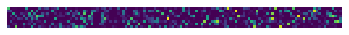

In [27]:
_ = plt.imshow(embedding.reshape(8, -1))
_ = plt.gca().axis('off')

In [28]:
embedding.shape

(1024,)

# Define the policy network
Now that we have a simple observation space to work with we can look at creating a policy network from it.
Our action space is 3D \[0., 1.\] unit cube (-1.,-1 for first dimension) which suggests we could sample each action dimension from a Beta distribution. The Beta distribution is defined by two non-negative parameters a and b so a simple policy network can be created by using a single fully connected layer with exponential activation function.

In [98]:
inputs = tf.keras.layers.Input(shape=(1024, ))
fc = tf.keras.layers.Dense(
    6, activation='exponential',  kernel_initializer='zeros',
    bias_initializer='zeros'
)(inputs)
unscaled_actions = tfp.layers.DistributionLambda(
    lambda x: tfd.Beta(x[...,:3], x[..., 3:], name='unscaled')
)(fc)
# Shift and scale: subtract min, scale by range, add min
shift_b1 = tfp.bijectors.Shift(env.action_space.low, name='shift_1')
scale_b = tfp.bijectors.Scale(env.action_space.high - env.action_space.low, name='scale')
shift_b2 = tfp.bijectors.Shift(-env.action_space.low, name='shift_2')
# Transform the individual Beta distributions to get correct output ranges
# and also combine into single event using tfd.Independent
scaled_actions = tfp.layers.DistributionLambda(
    lambda x: tfd.Independent(
        tfd.TransformedDistribution(
            distribution=x,
            bijector=tfp.bijectors.Chain([shift_b2, scale_b, shift_b1]),
            name='shift_scale'
        ),
        reinterpreted_batch_ndims=None,
        name='independent'
    ))(unscaled_actions)

network = tf.keras.Model(inputs, scaled_actions)

In [99]:
network.build(input_shape=(1024, ))

In [100]:
network.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 6150      
_________________________________________________________________
distribution_lambda_21 (Dist ((None, 3), (None, 3))    0         
_________________________________________________________________
distribution_lambda_22 (Dist ((None, 3), (None, 3))    0         
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________


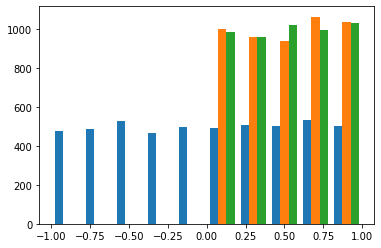

In [125]:
# Can sample from policy 
_ = plt.hist(network(embedding.reshape((1,-1))).sample(5000).numpy().reshape((-1, 3)))

In [102]:
next_action = network(embedding.reshape((1,-1)))

In [126]:
next_action.log_prob([0., 0., 0.])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6931472], dtype=float32)>

In [138]:
next_action.sample()[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.17625391, 0.119437  , 0.97266936], dtype=float32)>

In [165]:
def compute_loss(network, obs, act, weights):
    print(obs)
    print(act)
    print(weights)
    logp = network(obs).log_prob(act)
    return tf.reduce_mean(-(logp * weights))

In [168]:
# for training policy
def train_one_epoch():
    # MMcD Storing sequence of frames
    n_row_col = 2
    n_frame = n_row_col**2  # Square number for tiling
    buffer = tf.zeros((n_frame,) + env.observation_space.shape, dtype=tf.uint8)
    batch_size = 100
        
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # reset episode-specific variables
    obs = env.reset()       # first obs comes from starting distribution
    done = False            # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
    
    # collect experience by acting in the environment with current policy
    while True:

#         # rendering
#         if (not finished_rendering_this_epoch) and render:
#             env.render()

        buff_resized = tf.image.resize(
            seq_to_img(buffer, n_row_col), (img_ht, img_wd), method='nearest').numpy()
        time_ms, embedding = engine.run_inference(buff_resized.flatten())


        # save obs
        batch_obs.append(embedding.copy())

        
        # act in the environment
        act = network(embedding.reshape((1,-1))).sample()[0].numpy()
        # act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
        buffer = updated_buffer
        
        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)

        if done:
            # if episode is over, record info about episode
            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            batch_weights += [ep_ret] * ep_len

            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break

    # MMcD Optimizer for update step
    adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # take a single policy gradient update step
    # optimizer.zero_grad()
    batch_loss = compute_loss(network, obs=tf.convert_to_tensor(batch_obs), 
                              act=tf.convert_to_tensor(batch_acts), 
                              weights=tf.convert_to_tensor(batch_weights)
                            )
    updates = adam.get_updates(
        params=network.trainable_weights,
        # constraints=[],
        loss=batch_loss)
    
    return batch_loss, batch_rets, batch_lens

In [169]:
train_one_epoch()

Track generation: 1165..1460 -> 295-tiles track
Track generation: 1159..1453 -> 294-tiles track
tf.Tensor(
[[0.         0.23528478 0.16469935 ... 0.04705695 0.28234172 0.        ]
 [0.04705695 0.07058543 0.16469935 ... 0.         0.18822782 0.        ]
 [0.68232584 0.07058543 0.7293828  ... 0.         0.07058543 0.        ]
 ...
 [1.7646358  4.046898   0.16469935 ... 0.42351258 0.5176265  0.28234172]
 [2.0940344  3.7410278  0.11764239 ... 0.35292715 0.47056955 0.23528478]
 [2.0469775  3.8821988  0.11764239 ... 0.37645563 0.44704106 0.23528478]], shape=(1000, 1024), dtype=float32)
tf.Tensor(
[[ 0.20872426  0.1252885   0.02122058]
 [-0.33189642  0.85412323  0.1401515 ]
 [-0.22940731  0.48840925  0.9315034 ]
 ...
 [-0.6447742   0.49245512  0.2883023 ]
 [-0.45599937  0.7950263   0.7620641 ]
 [ 0.1504811   0.5412552   0.44896477]], shape=(1000, 3), dtype=float32)
tf.Tensor(
[-31.97279 -31.97279 -31.97279 -31.97279 -31.97279 -31.97279 -31.97279
 -31.97279 -31.97279 -31.97279 -31.97279 -31.97

ValueError: Variable <tf.Variable 'dense_11/kernel:0' shape=(1024, 6) dtype=float32> has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [ ]:
# MMcD Optimizer for update step
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
# take a single policy gradient update step
optimizer.zero_grad()
batch_loss = compute_loss(obs=batch_obs, 
                          act=batch_acts, 
                          weights=batch_weights
                        )
updates = adam.get_updates(
    params=network.trainable_weights,
    constraints=[],
    loss=loss)